# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

Note:
- Majority of time spent during experimentation right now is spent on building the forest. Meanwhile the queries are actually pretty fast.

In [8]:
import time
import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pytest

from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH
from shared.utils import recall, chamfer, timed
from shared.utils import build_multidoc_lsh, build_simple_lsh
from shared.retrieval import best_document, rank_documents
from shared.plotting import plot

sys.path.append(os.path.abspath("../src"))


# Quick test
A = np.array([[1, 0]], dtype=float)
B = np.array([[1, 0], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)
C = np.array([[1, 0], [0, 1], [np.sqrt(.1), np.sqrt(.9)], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)

assert timed(chamfer, A, B) == pytest.approx(1.0)
assert timed(chamfer, B, A) == pytest.approx(1 + np.sqrt(.5))
assert timed(chamfer, B, C) == pytest.approx(2)
assert timed(chamfer, B, B) == pytest.approx(2)
assert timed(chamfer, C, C) == pytest.approx(4)

chamfer took 0.0010 sec
chamfer took 0.0000 sec
chamfer took 0.0000 sec
chamfer took 0.0000 sec
chamfer took 0.0000 sec


In [9]:
# Hyperparameters and constants
n = 10                                # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 64                                  # dimension per vector
l = 10                                  # trees per forest
k = 5                                  # pivots to keep per node in tree
km = 20                                 # max depth of each tree
a = 10                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)

# Get normalized document and query vectors
data = rng.normal(size=(n, m, d)).astype(np.float32)
data /= np.linalg.norm(data, axis=-1, keepdims=True)

queries = rng.normal(size=(q, d)).astype(np.float32)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

distance = lambda a, b: -np.dot(a, b)


In [10]:
# Baseline

sims = np.array([chamfer(queries, doc_vecs) for doc_vecs in data], dtype=np.float32)
best_doc = int(np.argmax(sims))
best_score = float(sims[best_doc])
print(best_doc, best_score)

true_ranking = np.argsort(-sims)
print(true_ranking[:10])


1 7.72544527053833
[1 8 2 9 7 5 4 0 6 3]


In [11]:
# Experiment logic

experiments = {
        'l':  list(range(1, 41)),
        'k':  list(range(1, 41)),
        'km': list(range(1, 41)),
        'a':  list(range(1, 41))
}

defaults = dict(l=l, k=k, km=km, a=a)


def nearest_experiment(variable, values, defaults, build):
        sims, docs = [], []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(data, parameters['l'], parameters['k'], parameters['km'], d)
                sim, doc = timed(best_document, forest, queries, distance, parameters['a'])
                sims.append(sim)
                docs.append(doc)
        print(f"Finished nearest experiment: {variable}")
        return sims, docs
    
def recall_experiment(variable, values, defaults, build, num_items):
        recall_vals = []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(data, parameters['l'], parameters['k'], parameters['km'], d)
                ranking = timed(rank_documents, forest, queries, distance, parameters['a'])
                recall_vals.append(recall(true_ranking, ranking, num_items))
        print(f"Finished recall experiment: {variable}")
        return recall_vals
     
    



In [12]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = nearest_experiment(var, vals, defaults, build_simple_lsh)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    

best_document took 0.0036 sec
best_document took 0.0046 sec
best_document took 0.0075 sec
best_document took 0.0095 sec
best_document took 0.0114 sec
best_document took 0.0134 sec
best_document took 0.0157 sec
best_document took 0.0176 sec
best_document took 0.0206 sec
best_document took 0.0215 sec
best_document took 0.0235 sec
best_document took 0.0259 sec
best_document took 0.0268 sec
best_document took 0.0284 sec
best_document took 0.0309 sec
best_document took 0.0318 sec
best_document took 0.0336 sec
best_document took 0.0352 sec
best_document took 0.0363 sec
best_document took 0.0381 sec


KeyboardInterrupt: 

best_document took 0.0027 sec
best_document took 0.0033 sec
best_document took 0.0035 sec
best_document took 0.0046 sec
best_document took 0.0047 sec
best_document took 0.0051 sec
best_document took 0.0057 sec
best_document took 0.0061 sec
best_document took 0.0075 sec
best_document took 0.0068 sec
best_document took 0.0070 sec
best_document took 0.0077 sec
best_document took 0.0076 sec
best_document took 0.0082 sec
best_document took 0.0085 sec
best_document took 0.0093 sec
best_document took 0.0093 sec
best_document took 0.0097 sec
best_document took 0.0104 sec
best_document took 0.0104 sec
best_document took 0.0109 sec
best_document took 0.0108 sec
best_document took 0.0110 sec
best_document took 0.0117 sec
best_document took 0.0121 sec
best_document took 0.0124 sec
best_document took 0.0128 sec
best_document took 0.0131 sec
best_document took 0.0138 sec
best_document took 0.0133 sec
best_document took 0.0135 sec
best_document took 0.0145 sec
best_document took 0.0139 sec
best_docum

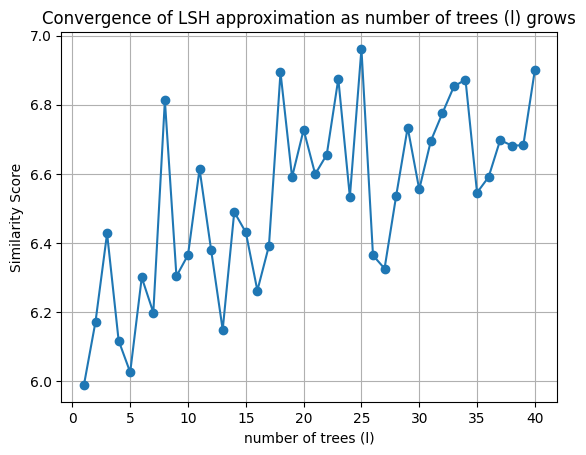

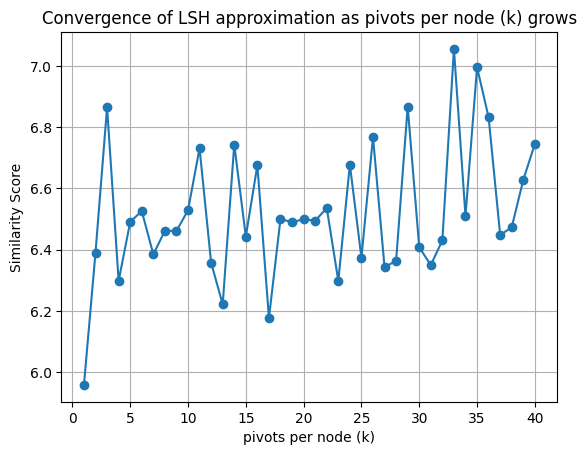

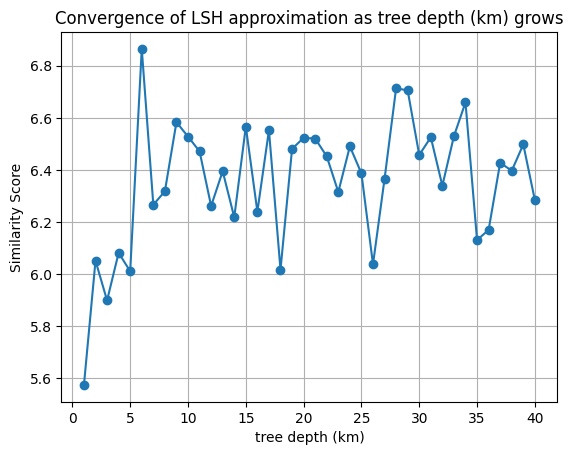

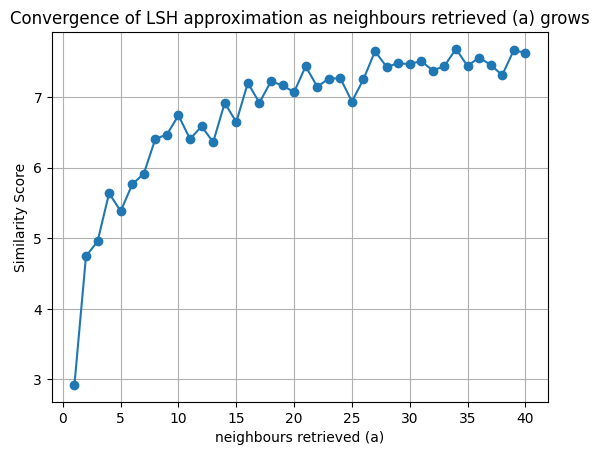

In [ ]:

# Evaluate multi-doc
results = {var: nearest_experiment(var, vals, defaults, build_multidoc_lsh) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')


rank_documents took 0.0025 sec
rank_documents took 0.0031 sec
rank_documents took 0.0038 sec
rank_documents took 0.0047 sec
rank_documents took 0.0053 sec
rank_documents took 0.0054 sec
rank_documents took 0.0056 sec
rank_documents took 0.0059 sec
rank_documents took 0.0076 sec
rank_documents took 0.0069 sec
rank_documents took 0.0080 sec
rank_documents took 0.0071 sec
rank_documents took 0.0084 sec
rank_documents took 0.0087 sec
rank_documents took 0.0089 sec
rank_documents took 0.0089 sec
rank_documents took 0.0093 sec
rank_documents took 0.0099 sec
rank_documents took 0.0109 sec
rank_documents took 0.0104 sec
rank_documents took 0.0111 sec
rank_documents took 0.0109 sec
rank_documents took 0.0123 sec
rank_documents took 0.0119 sec
rank_documents took 0.0121 sec
rank_documents took 0.0121 sec
rank_documents took 0.0129 sec
rank_documents took 0.0133 sec
rank_documents took 0.0137 sec
rank_documents took 0.0142 sec
rank_documents took 0.0139 sec
rank_documents took 0.0144 sec
rank_doc

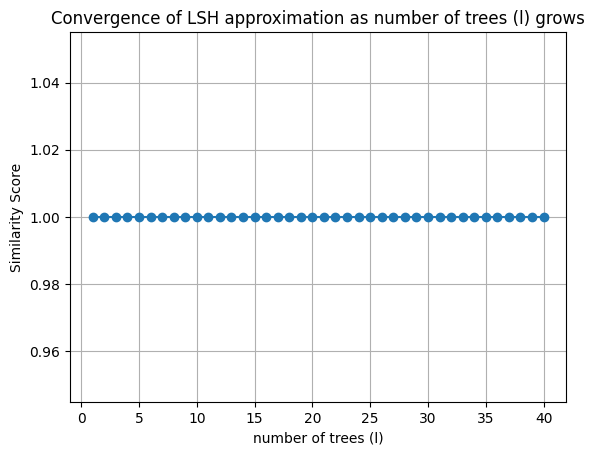

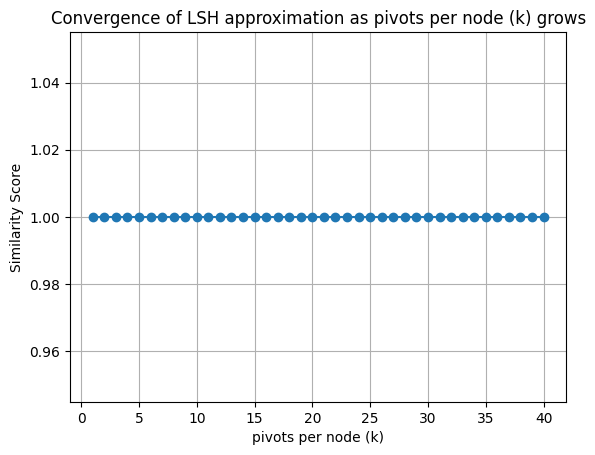

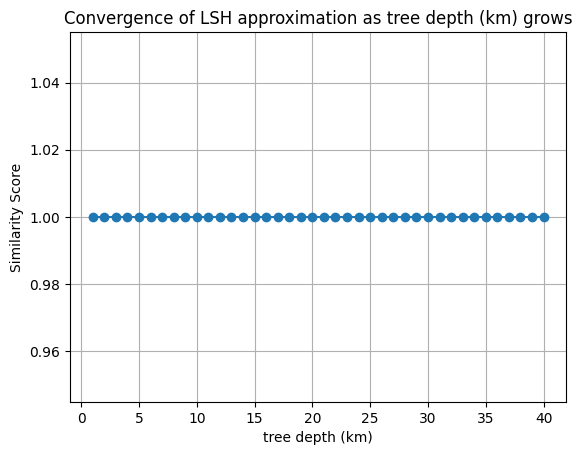

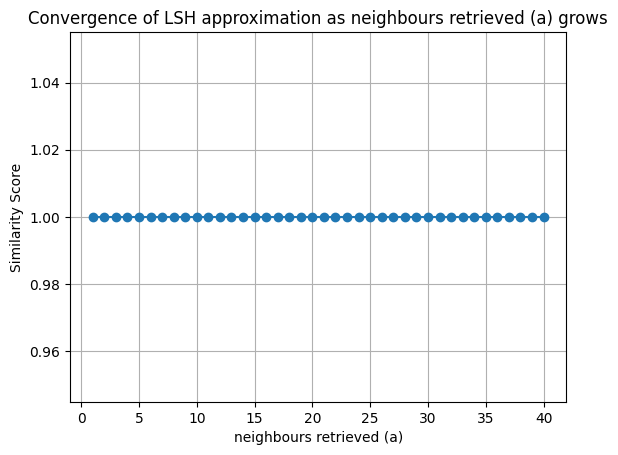

In [ ]:
# Evaluate multi-doc recall
results = {var: recall_experiment(var, vals, defaults, build_multidoc_lsh, 10) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'],  'number of trees (l)')
plot(experiments['k'],  results['k'],  'pivots per node (k)')
plot(experiments['km'], results['km'], 'tree depth (km)')
plot(experiments['a'],  results['a'],  'neighbours retrieved (a)')